# Another model for fun for old dataset

First of all we need to import all the necessary libraries.

In [5]:
import tensorflow as tensorflowimport
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, os.path
import csv
import tensorflow_hub as hub

batch_size = 32
img_size = 224
num_classes = 26

# Checking dataset images

Here we see if the dataset loaded properly and we can see the images.

(200, 200, 3)


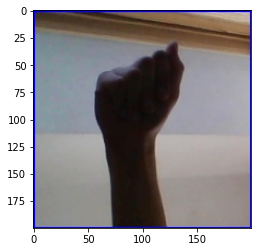

In [2]:
myimg = img.imread("dataset/train_images/A/A1.jpg")
print(myimg.shape)
plt.imshow(myimg)


# Like always, we will first check how the data is organized

We will see how the dataset is spread out and a general graph of the distribution of the data.

In [3]:
train_categories = []
train_samples = []
train_path = 'dataset/train_images/'

for i in os.listdir(train_path):
    train_categories.append(i)
    train_samples.append(len(os.listdir(train_path + i)))

test_samples = []
test_path = 'dataset/test_images/'
for i in os.listdir(test_path):
    test_samples.append(test_path + i)

print("Count of images in Training set:", sum(train_samples))
print("Count of images in Set set:", len(test_samples))

Count of images in Training set: 78000
Count of images in Set set: 26


Checking the distribution of the training data

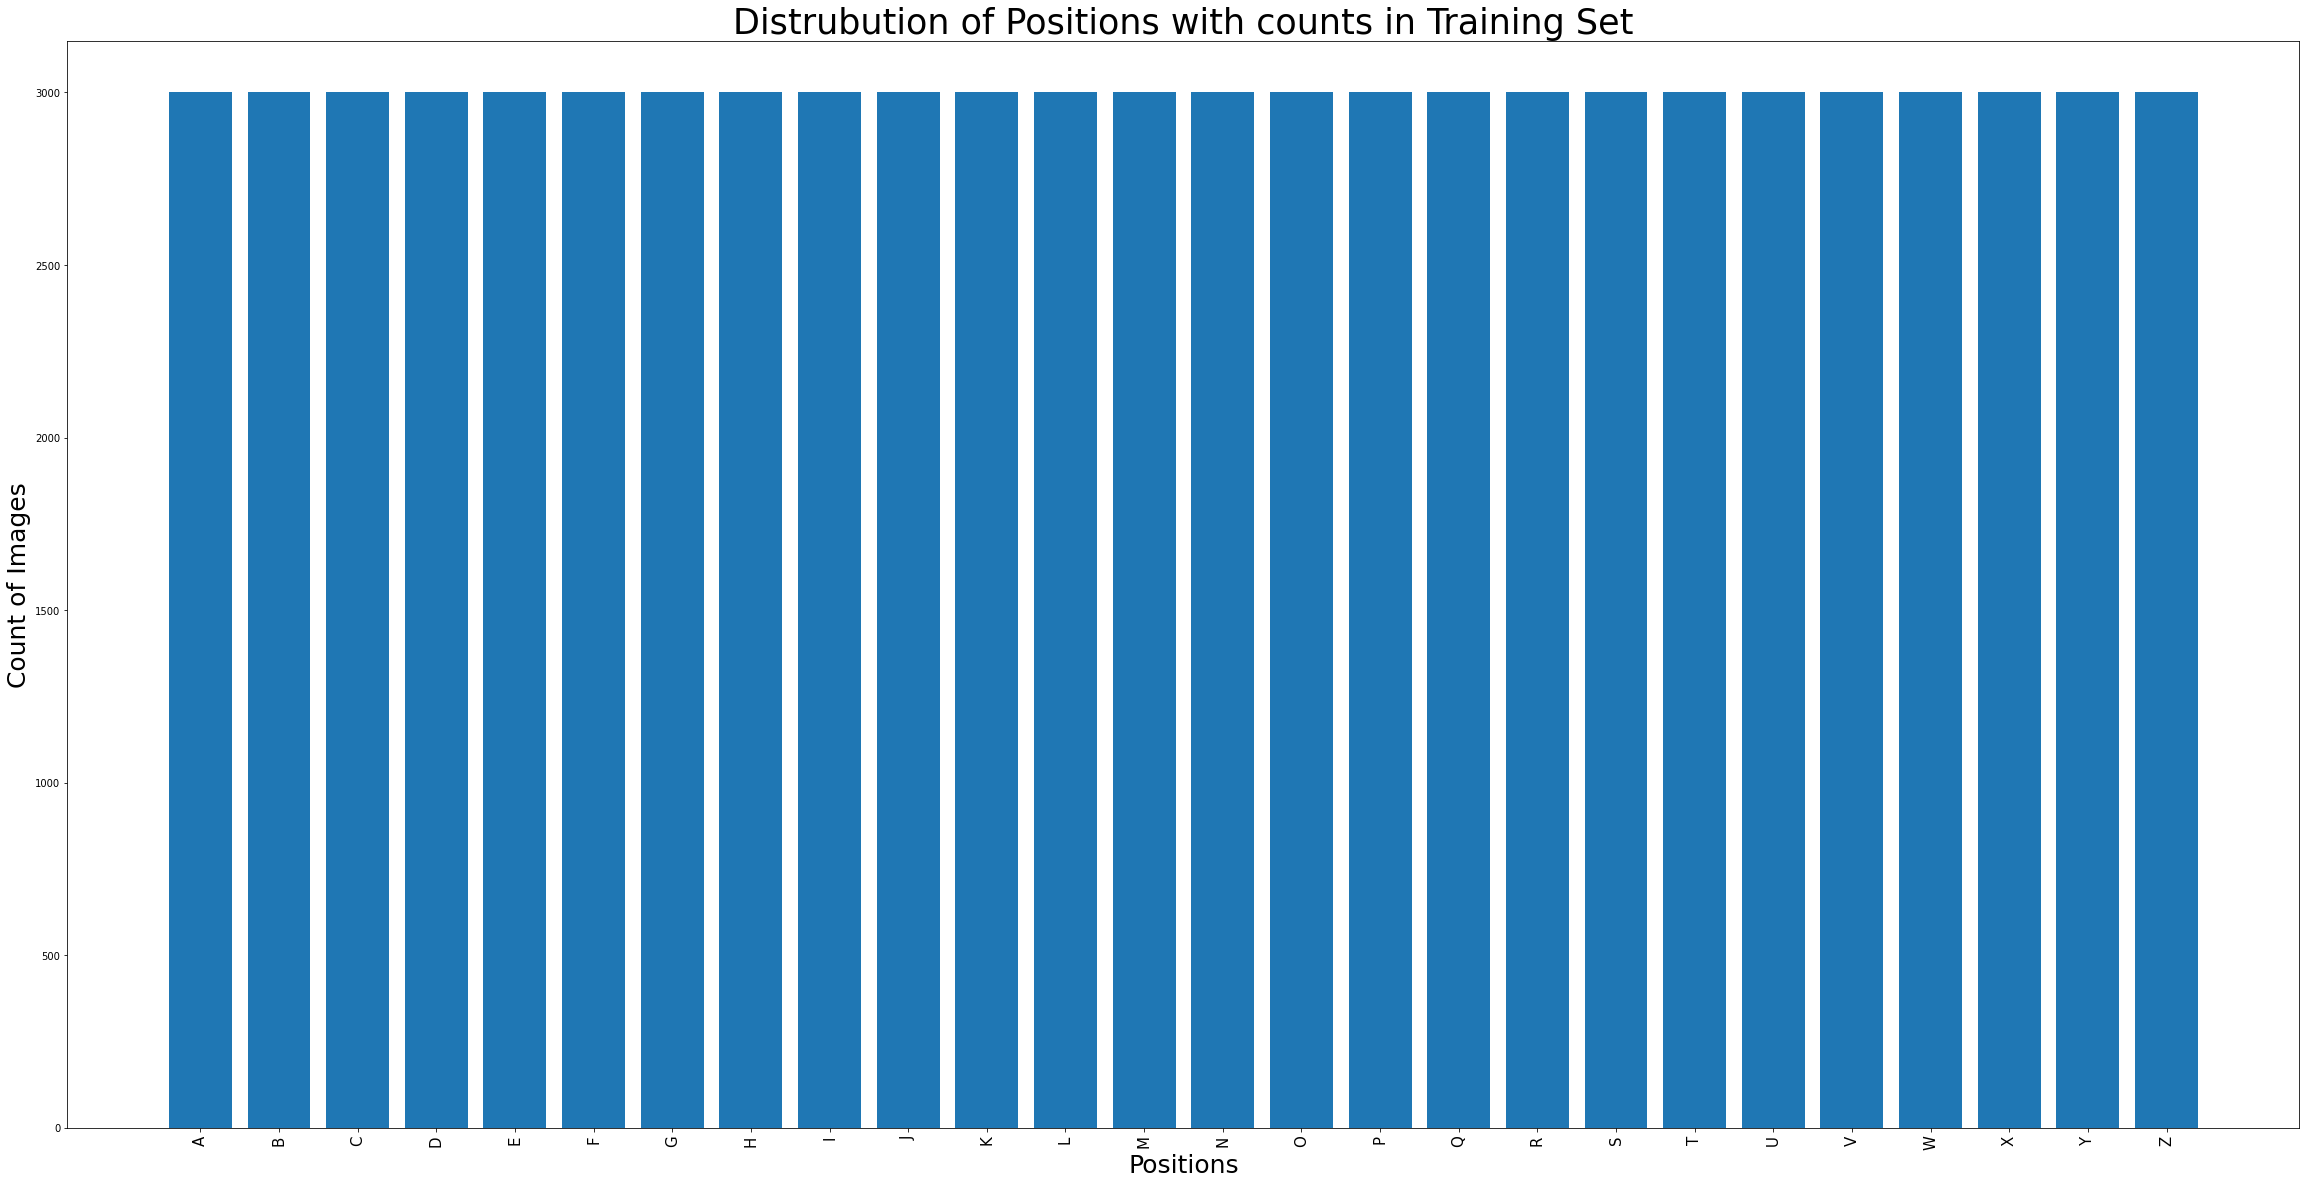

In [4]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
index = np.arange(len(train_categories))
plt.bar(index, train_samples)
plt.xlabel('Positions', fontsize=25)
plt.ylabel('Count of Images', fontsize=25)
plt.xticks(index, train_categories, fontsize=15, rotation=90)
plt.title('Distrubution of Positions with counts in Training Set', fontsize=35)
plt.show()

# Getting dataset from images

We will be using image dataset from directory

In [6]:
def get_dataset(path, batch_size, img_size):
    train_dataset = image_dataset_from_directory(path,
                                           shuffle=True,
                                           batch_size=batch_size,
                                           seed = 1447,
                                           image_size=(img_size, img_size),
                                           validation_split=0.2,
                                           subset="training")
    val_dataset = image_dataset_from_directory(path,
                                            shuffle=True,
                                            batch_size=batch_size,
                                            seed = 1447,
                                            image_size=(img_size, img_size),
                                            validation_split=0.2,
                                            subset="validation")
    return train_dataset, val_dataset

train, val = get_dataset(train_path, batch_size, img_size)

Found 78000 files belonging to 26 classes.
Using 62400 files for training.
Found 78000 files belonging to 26 classes.
Using 15600 files for validation.


In [6]:
print(val)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Next, the test dataset, since we dont have classes for those, we will just store the file names in an array

In [7]:
def generate_test_labels(test_location="dataset/test_images"):

    img_id = []
    for fileName in os.listdir(test_location):
        img_id.append(fileName)
    return img_id




test_labels = generate_test_labels()
print(test_labels)

label_dict = {}
for i, line in enumerate(open("wnids.txt", "r")):
    label_dict[line.rstrip("\n")] = int(i)

test_int = [label_dict[x[0]] for x in test_labels]
print(test_int)


['A_test.jpg', 'B_test.jpg', 'C_test.jpg', 'D_test.jpg', 'E_test.jpg', 'F_test.jpg', 'G_test.jpg', 'H_test.jpg', 'I_test.jpg', 'J_test.jpg', 'K_test.jpg', 'L_test.jpg', 'M_test.jpg', 'N_test.jpg', 'O_test.jpg', 'P_test.jpg', 'Q_test.jpg', 'R_test.jpg', 'S_test.jpg', 'T_test.jpg', 'U_test.jpg', 'V_test.jpg', 'W_test.jpg', 'X_test.jpg', 'Y_test.jpg', 'Z_test.jpg']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


# The Actual Model

We will be keeping things simple with a simple transfer learning model using the MobileNet model.

In [14]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(feature_extractor_model,
                                             input_shape=(img_size, img_size,
                                                          3),
                                             trainable=False)

### Optimized Neural Network
model = keras.models.Sequential()

# Model Layers
model.add(keras.layers.Rescaling((1. / 255)))
model.add(feature_extractor_layer)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='swish'))
model.add(keras.layers.Dense(256, activation='swish'))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.build(input_shape=(None, img_size, img_size, 3))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 26)                6682      
                                                                 
Total params: 3,838,810
Trainable params: 1,580,826
No

Next, we define two callbacks to save the best model and to stop the training if the model is not improving.

In [15]:
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=4,
                                                 verbose=1,
                                                 factor=0.4,
                                                 min_lr=0.0001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.00001,
                                           patience=8,
                                           mode='auto',
                                           restore_best_weights=True)


Finally, training the model.

In [17]:
num_epochs = 100
history = model.fit(train,
                    epochs=num_epochs,
                    validation_data=val,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[early_stop, lr_reduction],)


Epoch 1/100
1950/1950 [==============================] - 64s 32ms/step - loss: 0.1982 - accuracy: 0.9364 - val_loss: 0.0644 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 2/100
1950/1950 [==============================] - 58s 30ms/step - loss: 0.0682 - accuracy: 0.9780 - val_loss: 0.0369 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 3/100
1950/1950 [==============================] - 59s 30ms/step - loss: 0.0518 - accuracy: 0.9838 - val_loss: 0.0541 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 4/100
1950/1950 [==============================] - 58s 30ms/step - loss: 0.0383 - accuracy: 0.9883 - val_loss: 0.0385 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 5/100
1950/1950 [==============================] - 59s 30ms/step - loss: 0.0360 - accuracy: 0.9896 - val_loss: 0.0242 - val_accuracy: 0.9927 - lr: 0.0010
Epoch 6/100
1950/1950 [==============================] - 58s 30ms/step - loss: 0.0314 - accuracy: 0.9912 - val_loss: 0.0143 - val_accuracy: 0.9953 - lr: 0.0010
Epoch 7/100
1950/1950 [=================

# Finished training!

Now that everything is finished training, it is time to check the val accuracy one last time and move on to the test dataset.

In [68]:
print("Final Validation Accuracy:")
model.evaluate(val)

Final Validation Accuracy:
488/488 [==============================] - 21s 43ms/step - loss: 0.0030 - accuracy: 0.9994


[0.0030198583845049143, 0.9993589520454407]

First we will load the test images from the test directory and run them through the model, using a technique called time-test-augmentation to increase accuracy.


In [82]:
test = []
for i in test_labels:
    newimg = cv2.imread(test_path + i)
    newimg = cv2.resize(newimg, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    test.append(newimg)

test = np.array(test)

predictions = model.predict(test)
y_predict_max = np.argmax(predictions, axis=1)
print(y_predict_max)

1/1 [==============================] - 0s 29ms/step
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 22 23
 24 24]


Then we will calculate accuracy using our previous test labels

In [83]:
total = 0.0
correct = 0.0
for x, y in zip(test_int, y_predict_max):
    total += 1
    if x == y:
            correct += 1

accuracy = correct / total
print(accuracy)

0.9230769230769231


Final Results: 
92% accuracy on the test dataset, not bad!
Slightly odd that we are failing a Z image, but due to the nature of the dataset, it is not a big deal.
In the future, fine tuning and more data augmentation could be used to increase accuracy.


# VGG Model for Funsies!

Here we will be using a VGG model to see if we can get better results.

In [11]:
print(train)
train = train.map(lambda x, y:
                  (tf.keras.applications.vgg16.preprocess_input(x), y))
val = val.map(lambda x, y:
              (tf.keras.applications.vgg16.preprocess_input(x), y))


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [12]:
### Optimized Neural Network
model = keras.models.Sequential()

vgglayer = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3), pooling = 'max')
vgglayer.trainable = False

# Model Layers
model.add(vgglayer)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.build(input_shape=(None, img_size, img_size, 3))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=4,
                                                 verbose=1,
                                                 factor=0.4,
                                                 min_lr=0.0001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.00001,
                                           patience=8,
                                           mode='auto',
                                           restore_best_weights=True)
batch_size = 4

num_epochs = 5
history = model.fit(
    train,
    epochs=num_epochs,
    validation_data=val,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stop, lr_reduction],
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 26)                6682      
                                                                 
Total params: 14,852,698
Trainable params: 138,010
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/5
1950/1950 [==============================] - 147s 72ms/step - loss: 0.8505 - accuracy: 0.8808 - val_loss: 0.2745 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 2/5
1

Each epoch took way too long to train, so I stopped it after 5 epochs. Time to test the model!

In [18]:
test = []
for i in test_labels:
    newimg = cv2.imread(test_path + i)
    newimg = cv2.resize(newimg,
                        dsize=(img_size, img_size),
                        interpolation=cv2.INTER_CUBIC)
    test.append(newimg)

test = np.array(test)
print(test_int)

predictions = model.predict(test)
y_predict_max = np.argmax(predictions, axis=1)
print(y_predict_max)

total = 0.0
correct = 0.0
for x, y in zip(test_int, y_predict_max):
    total += 1
    if x == y:
        correct += 1

accuracy = correct / total
print(accuracy)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
1/1 [==============================] - 0s 18ms/step
[14  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 23 19  1 21 22 23
 24  8]
0.8461538461538461


84.6% Final Accuracy after 5 Epochs, not the worst, but not the best either. Pretty good honestly considering that we had no image augmentation or fine tuning.